In [552]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.api.types import is_string_dtype,is_numeric_dtype
import operator
import sys

import json

def preprocessing(train,test,valid):
    m,n = train.shape
    m_test = test.shape[0]
    m_valid = valid.shape[0]
    df = pd.concat([train,test,valid],axis=0)
    df = regexOperation(df)
    bins_age = pd.IntervalIndex.from_tuples([(0, 20), (20, 40), (40, 60),(60,150)])
    bins_hours = pd.IntervalIndex.from_tuples([(0, 40), (40, 140)])
    x = pd.cut(df['Age'].tolist(),bins_age)
    x.categories = ['upto20','20to40','40to60','60above']
    df['Age'] = x
    df['Age'] = df['Age'].astype('str')
    y = pd.cut(df['Hour per Week'].tolist(),bins_hours)
    y.categories = ['less than 40','greater than 40']
    df['Hour per Week'] = y
    df['Hour per Week'] = df['Hour per Week'].astype('str')
    df['Education Number']= df['Education Number'].where(df['Education Number']>12,'others')
    df['Native Country']= df['Native Country'].where(df['Native Country']=='United-States','Not US')   
    df.drop(['Education','Fnlwgt','Capital Gain','Capital Loss','Rich?'],axis=1,inplace=True)
    print(df.shape)
    return df.iloc[:m,:].astype('str'),df.iloc[m:m+m_test,:].astype('str'),df.iloc[m+m_test:,:].astype('str')

def onehotEncoder(array,k_class,column_name,dict_map):

    '''
    @array -  encoded array
    @k_class - number of unique classes in array
    '''
    #to ensure the type of input is one dimensional array
    if(type(array)==list):
        array = np.array(array)
    assert len(array.shape)==1

    #initializing (m,k_classes) dataframe as one hot encoded
    onehotencoded = np.zeros((array.shape[0],k_class))
    array = array.reshape((array.shape[0],))

    #loop for each data point in array
    for i in range(array.shape[0]):
        onehotencoded[i,array[i]-1] = 1
    onehotencoded = pd.DataFrame(onehotencoded,columns=[column_name+"."+dict_map[i][0] for i in range(len(dict_map))])

    return onehotencoded

def decode(array,mapping):

    '''
        @mapping- python dict where keys and values and encoded and true values respectively
        @array - encoded array
    '''
    #convert to list type
    array_list = array.tolist()
    for i in range(array.shape[0]):
        array_list[i] = mapping[array[i]-1]
    return np.array(array_list)

def print_tree(dtree):
    tree_str = json.dumps(dtree, indent=4)
    tree_str = tree_str.replace("\n    ", "\n")
    tree_str = tree_str.replace('"', "")
    tree_str = tree_str.replace(',', "")
    tree_str = tree_str.replace("{", "")
    tree_str = tree_str.replace("}", "")
    tree_str = tree_str.replace("    ", " | ")
    tree_str = tree_str.replace("  ", " ")

    print(tree_str)
    
def encoder(array,unique_classes):

    '''
        @array -  input categorical feature which is to be encoded 
        @unique_classes -  input list of unique classes in array
    '''
    array = array.reshape((array.shape[0],))

    #initializing a ditionary to store mapping of true classes to encoded value
    mapping={}
    for i in range(len(unique_classes)):
        mapping[unique_classes[i]]=i+1
    
    mapping_sortedlist = sorted(mapping.items(), key=operator.itemgetter(1))
    #encoding
    for j in range(array.shape[0]):
        if(array[j] not in list(mapping.keys())):
            array[j] = None
        else:
            array[j] = list(mapping.keys()).index(array[j])+1
    #returning encoded array
    return array.reshape((array.shape[0],)),mapping_sortedlist


def regexOperation(data):
    data.columns = data.columns.str.lstrip()
    for col in data.columns:
        if(is_string_dtype(data[col])):
            data[col] = data[col].str.lstrip()
    return data

def read_inputs(df):
    dataframe = df.copy()
    #list of catergoircal columns
    categorical_columns = [col for col in dataframe.columns if is_string_dtype(dataframe[col])]
    
    #list of numerical columns
    numeric_columns =  [col for col in dataframe.columns if is_numeric_dtype(dataframe[col])]
    
    #list of unique lables for each categorical columns in dataframe
    label_order = [list(dataframe[name].unique()) for name in categorical_columns]
    

    resultant_dataframe = dataframe
    
    for i,column in enumerate(categorical_columns):
            uniquec = label_order[i]
            feat= dataframe[column].values
            arr,map_train = encoder(feat,uniquec)
            cc = onehotEncoder(arr,len(uniquec),column,map_train)
            resultant_dataframe=pd.concat([resultant_dataframe,cc],axis=1)
            
    resultant_dataframe.drop(categorical_columns,axis=1,inplace=True)
                
    #print(Y.shape)
    X = dataframe
    return resultant_dataframe.astype('uint8')


class Node:
    def __init__(self,feature=None,pos_examples=None,neg_examples=None):
        self.pos_examples = pos_examples
        self.neg_examples = neg_examples
        self.feature = feature
        self.label = None
        self.leftchild=None 
        self.rightchild = None 
        self.parent = None

    def set_leftchild(self,node):
        self.leftchild = node
        node.parent = self
    
    def set_rightchild(self,node):
        self.rightchild =node
        node.parent=self
    
    def get_rightchild(self):
        return self.rightchild
    
    def get_leftchild(self):
        return self.leftchild
    


class DecisionTree:
    def __init__(self,trainx,trainy,max_depth,column_order_list,min_sample_leaf=None):
        self.trainx = trainx
        self.trainy = trainy
        self.max_depth = max_depth
        self.min_sample_leaf =min_sample_leaf
        self.myTree = {}
        self.ordered_column_name = column_order_list
        self.isroot_set = False
        self.root = None

    def shannonEntropy(self,data):
        '''
        array of shape (m X n)
        '''
        data = data.copy()
        entropy = 0
        pos_data = data[data[:,-1]==1]
        neg_data = data[data[:,-1]==0]
        prob_pos = (pos_data.shape[0]/data.shape[0])
        prob_neg = (neg_data.shape[0])/data.shape[0]
        entropy = - prob_pos*np.log2(prob_pos+1e-6) - prob_neg*np.log2(prob_neg+1e-6) 
        return entropy
    

    def bestFeatureSelect(self,data):
        data_copy = data.copy()
        bestinfo_gain = 0
        init_entropy = self.shannonEntropy(data_copy)
        best_feat =-1
        for feat in range(data_copy.shape[1]-1):
            yes_response = data_copy[data_copy[:,feat]==1]
            no_response = data_copy[data_copy[:,feat]==0]
            if(yes_response.shape[0]>0  and no_response.shape[0]>0 ):
                entropy_yes = self.shannonEntropy(yes_response)
                entropy_no = self.shannonEntropy(no_response)

                prob_yes = float(yes_response.shape[0]/data_copy.shape[0])
                prob_no = float(no_response.shape[0]/data_copy.shape[0])
                info_gain= init_entropy -float(prob_yes*(entropy_yes))-float(prob_no*(entropy_no))

                if(info_gain > bestinfo_gain):
                    bestinfo_gain = info_gain
                    best_feat= feat
        return best_feat
    

    def majority_count(self,data):
        data = data.copy()
        pos = data[data[:,-1]==1].shape[0]
        neg = data[data[:,-1]==0].shape[0]
        if(pos>neg):
            return 1
        else:
            return 0
    
    def create_decision_tree(self,data,column_list):
        pos_exp = data[data[:,-1]==1].shape[0]
        neg_exp = data[data[:,-1]==0].shape[0]
        if(data.shape[1]==2 or data.shape[0]<self.min_sample_leaf):
            node = Node(pos_examples=pos_exp,neg_examples=neg_exp)
            label = self.majority_count(data)
            node.label = label
            return label,node
        
        if(len(np.unique(data[:,-1]))==1):
            node=Node(pos_examples=pos_exp,neg_examples=neg_exp)
            label = data[0,-1]
            node.label = label
            return label,node
        
        best_feat = self.bestFeatureSelect(data)

        right_split = data[data[:,best_feat]==1]
        right_split = np.hstack((right_split[:,:best_feat],right_split[:,best_feat+1:]))
        left_split = data[data[:,best_feat]==0]
        left_split = np.hstack((left_split[:,:best_feat],left_split[:,best_feat+1:]))

        column_name = column_list[best_feat]
        if(self.isroot_set==False):
            node = Node(column_name)
            self.root = node
            self.isroot_set = True
        else:
            node = Node(column_name)
        node.pos_examples = pos_exp
        node.neg_examples = neg_exp

        column_list = column_list[:best_feat]+column_list[best_feat+1:]

        myTree_branch = {column_name+"_0":{},column_name+"_1":{}}

        myTree_branch[column_name+"_0"],leftchild = self.create_decision_tree(left_split,column_list) 
        node.set_leftchild(leftchild)
        myTree_branch[column_name+"_1"],rightchild = self.create_decision_tree(right_split,column_list)
        node.set_rightchild(rightchild)
        return myTree_branch,node
    

    def get_label(self,feat_vector):
        curr_node = self.root
        while(curr_node!=None):
            feat_splitted = curr_node.feature
            if(feat_splitted is not None):

                feat_index = self.ordered_column_name.index(feat_splitted)
                parent_node = curr_node
                if(feat_vector[0,feat_index]==0):
                    curr_node = curr_node.leftchild
                else:
                    curr_node = curr_node.rightchild
                
                if(curr_node==None):
                    if(parent_node.label!=None):
                        return parent_node.label
                    else:
                        if(parent_node.pos_examples>=parent_node.neg_examples):
                            return 1
                        else:
                            return 0
            else:
                    if(curr_node.label!=None):
                        return curr_node.label
                    else:
                        if(curr_node.pos_examples>=curr_node.neg_examples):
                            return 1
                        else:
                            return 0

        return -1

    def predict(self,X):
        prediction = []
        for i in range(X.shape[0]):
            curr_feat_vector = X[i,:].reshape((1,X.shape[1]))
            label = self.get_label(curr_feat_vector)
            prediction.append(label)
        return prediction



In [553]:
train_file = "train.csv"
valid_file = "valid.csv"
test_file = "test_public.csv"
valid_pred_file = "valid_pred.txt"
test_pred_file = "test_pred.txt"


train_df = pd.read_csv(train_file)
testdf = pd.read_csv(test_file)
valid_df = pd.read_csv(valid_file)

trainy = train_df[" Rich?"].values.reshape((train_df.shape[0],1))

train,test,valid = preprocessing(train_df,testdf,valid_df)
trainx = read_inputs(train)
testx = read_inputs(test)
validx = read_inputs(valid)

cols = list(trainx.columns)
trainx = trainx.values
testx = testx.values
validx = validx.values


dt = DecisionTree(trainx,trainy,5,cols,min_sample_leaf=10)

train  = np.hstack((trainx,trainy))
dtree,node = dt.create_decision_tree(train,cols)

(33000, 10)


In [555]:
pred_test = dt.predict(testx)
pred_val = dt.predict(validx)
# accuracy = [1 if x==y else 0 for (x,y) in zip(pred,valy)]
# acc = sum(accuracy)/float(len(accuracy))
# print(acc)
with open(test_pred_file,"w") as f:
   f.write("\n".join(str(x) for x in pred_test))

with open(valid_pred_file,"w") as f:
   f.write("\n".join(str(x) for x in pred_val))

In [558]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

In [559]:
tree.fit(trainx,trainy)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [560]:
tree.predict(testx)

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [367]:
df_copy = df.copy()

In [409]:
for col in df.columns:
    print(col,len(df[col].unique()))

Age 4
Work Class 7
Fnlwgt 20211
Education Number 5
Marital Status 7
Occupation 14
Relationship 6
Race 5
Sex 2
Capital Gain 118
Capital Loss 91
Hour per Week 94
Native Country 2
Rich? 3


In [408]:
df.drop('Education',axis=1,inplace=True)

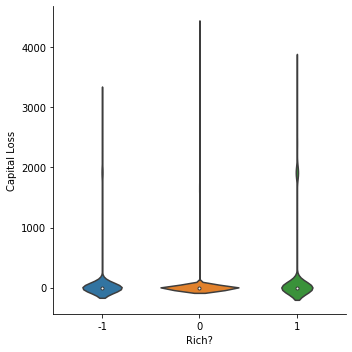

In [421]:
import seaborn as sns
sns.catplot(x = 'Rich?',y='Capital Loss',data=df,kind='violin')

In [415]:
df['Fnlwgt'].describe()

count    3.000000e+04
mean     1.896966e+05
std      1.050067e+05
min      1.376900e+04
25%      1.176468e+05
50%      1.786860e+05
75%      2.376560e+05
max      1.484705e+06
Name: Fnlwgt, dtype: float64

In [387]:
bins = pd.IntervalIndex.from_tuples([(0, 20), (20, 40), (40, 60),(60,150)])

In [392]:
df['Age'] = pd.cut(df['Age'],bins,labels=['upto20','20to40','40to60','60above'])

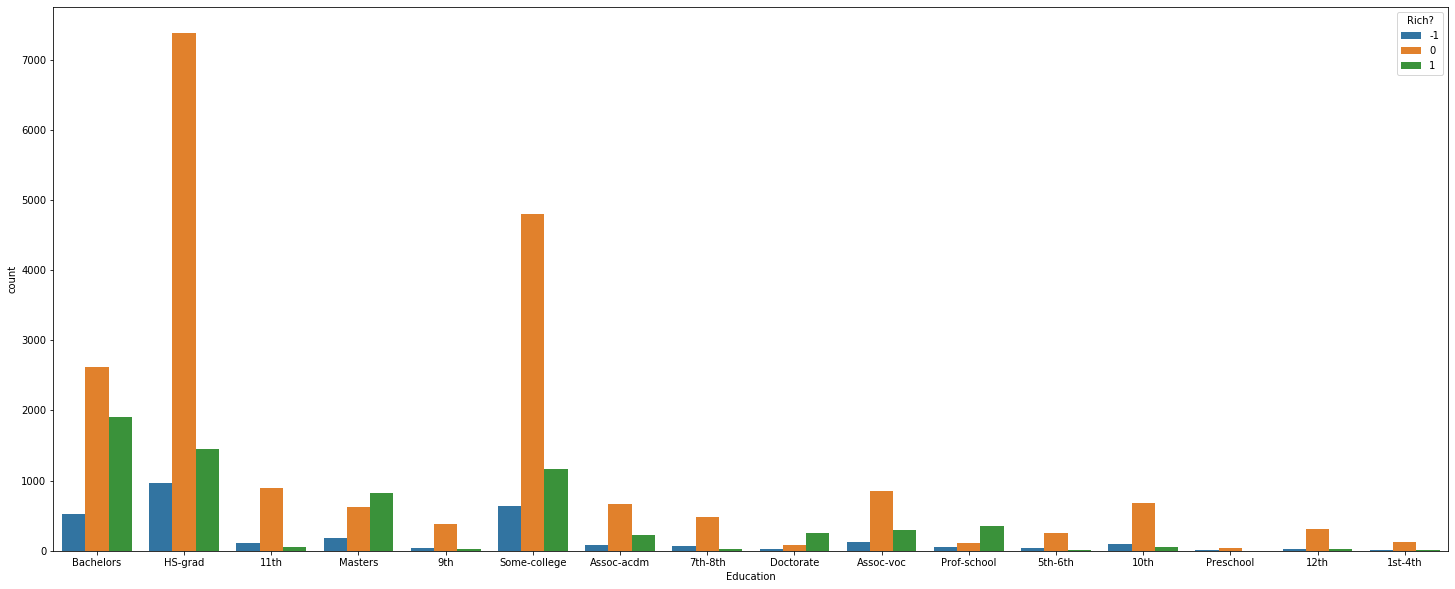

In [400]:
plt.figure(figsize=(25,10))
sns.countplot(df['Education'],hue=df['Rich?'])

In [404]:
df['Education Number']= df['Education Number'].where(df['Education Number']>12,'others')

In [375]:
# df['Native Country']= df['Native Country'].where(df['Native Country']=='United-States','Not US')   

In [377]:
df['Native Country'].value_counts()

United-States    27370
Not US            2630
Name: Native Country, dtype: int64

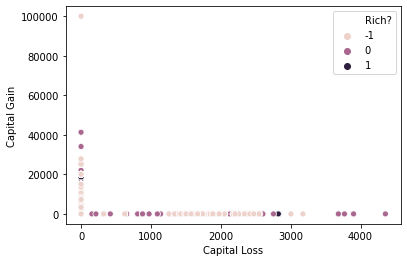

In [338]:
sns.scatterplot(y='Capital Gain',x='Capital Loss',hue='Rich?',data=df)

In [345]:
df['Hour per Week'].describe()

count    30000.000000
mean        40.911000
std         11.952633
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hour per Week, dtype: float64

In [405]:
categorical_columns = [col for col in df.columns if is_string_dtype(df[col])]
numeric_columns = [col for col in df.columns if is_numeric_dtype(df[col])]
dict ={}
for col in categorical_columns:
    dict[col]=df[col].unique()

In [406]:
categorical_columns,numeric_columns

(['Age',
  'Work Class',
  'Education',
  'Education Number',
  'Marital Status',
  'Occupation',
  'Relationship',
  'Race',
  'Sex',
  'Native Country'],
 ['Fnlwgt', 'Capital Gain', 'Capital Loss', 'Hour per Week', 'Rich?'])

In [419]:
def preprocessing(df):
    bins_age = pd.IntervalIndex.from_tuples([(0, 20), (20, 40), (40, 60),(60,150)])
    bins_hours = pd.IntervalIndex.from_tuples([(0, 40), (40, 140)])
    df['Age'] = pd.cut(df['Age'],bins_age,labels=['upto20','20to40','40to60','60above'])
    df['Hour per Week'] = pd.cut(df['Hour per Week'],bins_hours)
    df['Education Number']= df['Education Number'].where(df['Education Number']>12,'others')
    df['Native Country']= df['Native Country'].where(df['Native Country']=='United-States','Not US')   
    df.drop(['Education','Fnlwgt','Capital Gain','Capital Loss'],axis=1,inplace=True)
    
    return df